In [86]:
import xarray as xr
import pandas as pd
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

## Load Airpublic sensor data from colocation at MY1 AURN station

In [87]:
# load 
df = pd.read_csv('airpublic_colocation_raw_CO_NO.csv')
df.pm10 = df.pm10.astype(float)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.sort_values(by='timestamp')
 

In [88]:
df.head().T

,0,1,2,3,4
Unnamed: 0,2141,2140,2139,2138,2137
altitude,0,0,75,81.3,81
gas_temp,32.7,258.2,255,255,258.2
gps_fix,0,0,1,1,1
heading,3,3,152.1,249.4,285.7
humidity,50,51.1,50.4,50.7,50.7
latitude,0.89,0.39,51.5228,51.5229,51.5229
lonet_bat,93,96,92,94,93
longitude,86.4,69.6,-0.15468,-0.15471,-0.154737
pm1,0.538,0.827,4.072,1.905,1.883


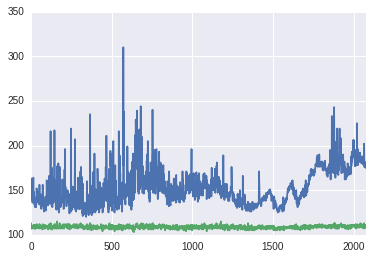

In [89]:
df.raw_CO_working.plot()
df.raw_CO_aux.plot()

# Convert co voltage to ppb


In [90]:
ANALOG_REF_VOLTAGE = 3.3;
    
# AFE board serial number 12-000027
# sensor CO A4 serial number 132950238

CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 268;
CO_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 42;

CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 262;
CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 10;
CO_SENSITIVITY = 0.228; # mv/ppb

def convert_co(CO_working_mv=None, CO_aux_mv=None, temp_correction = +1):
    # temp corretion is +1 up to 20 deg Cels, then -1, then -0.7 after 30C
    
    scaled_working = CO_working_mv - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  - CO_WORKING_ELECTRODE_SENSOR_ZERO_MV
    
    scaled_aux =  CO_aux_mv - CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV * temp_correction - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV   
    
    return  (scaled_working -  scaled_aux )/CO_SENSITIVITY

In [91]:
df['co_ppb'] = df[['raw_CO_working','raw_CO_aux']].apply(lambda x: convert_co(x.values[0], x.values[1]), axis=1)

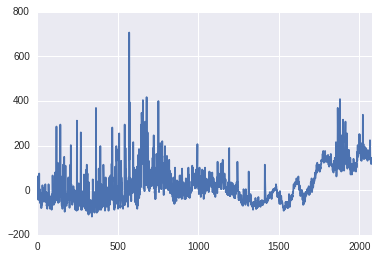

In [92]:
df.co_ppb.plot()

In [93]:
df.co_ppb.describe()

count    2077.000000
mean       23.571417
std        82.212210
min      -118.488038
25%       -39.415205
50%         4.408293
75%        70.279638
max       706.128655
Name: co_ppb, dtype: float64

## One hour averages

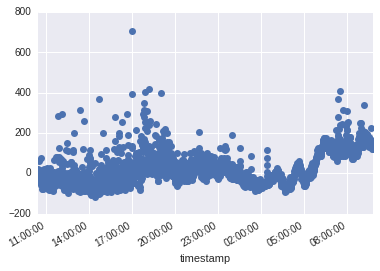

In [94]:
ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').co_ppb.plot(linestyle='none', marker='o')
#ds = ds.set_coords(['timestamp','id'])
#ds = ds.set_coords(['timestamp','id'])

## Compare to kings measurements from MY1 station

In [95]:
# load kings

df_kings_vol = pd.read_csv('my1_volume_18jan.csv')
df_kings_vol['timestamp'] = pd.to_datetime(df_kings_vol.date)

def filter_by_time(df):
    time = (df.timestamp >= '2017-01-17 13:00') & (df.timestamp <= '2017-01-18 12:00')
    return df[time]

# co is in ppm
df_kings_vol.co = 1000 * df_kings_vol.co

df_kings_vol = filter_by_time(df_kings_vol)
df_kings_vol = df_kings_vol.set_index('timestamp')
ds_kings_vol = xr.Dataset.from_dataframe(df_kings_vol)
kings_prefix = dict([(v, 'kings_'+v) for v in ds_kings_vol.data_vars])

def compare(ds_merged, airpublic_measure, kings_measure):
    ds_merged_one = ds_merged[[airpublic_measure, kings_measure]]
    # ds_merged_one['error'] = ds_merged_one[kings_measure] - ds_merged[airpublic_measure]
    #ds_merged_one.sel(datetime=example_date).to_dataframe().plot()
    ds_merged_one.to_dataframe().plot()
    sns.pairplot(ds_merged_one.to_dataframe().dropna().reset_index(), vars=ds_merged_one.data_vars)
    print ds_merged_one.to_dataframe().describe()

         kings_co      co_ppb
count   19.000000   20.000000
mean   492.543860   24.000907
std    221.803333   59.295664
min    200.000000  -52.135116
25%    345.833333  -21.069975
50%    450.000000   17.351366
75%    537.500000   57.667147
max    950.000000  141.001313


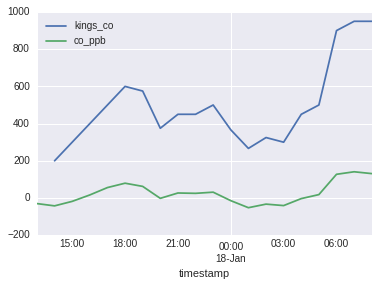

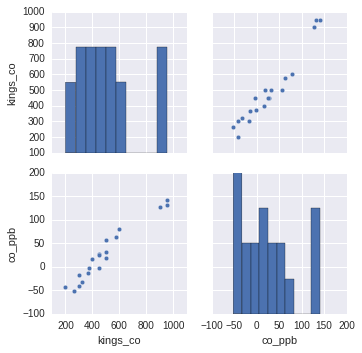

In [96]:
ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
compare(ds_merged,'kings_co','co_ppb')

## NO2 conversion


In [97]:
# AFE board serial number 12-000027
# sensor NO2 A43F serial number 212060336
NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 2;
NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 0;
NO2_SENSITIVITY = 0.197; # mv/ppb

def convert_no2(NO2_working_mv=None, NO2_aux_mv=None, temp_correction = +1.09):
    # temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C    
    
    scaled_aux =  NO2_aux_mv - NO2_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV * temp_correction - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV
    
    scaled_working = NO2_working_mv - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  - NO2_WORKING_ELECTRODE_SENSOR_ZERO_MV

    return  (scaled_working -  scaled_aux )/NO2_SENSITIVITY

In [98]:
df['no2_ppb'] = df[['raw_NO2_working','raw_NO2_aux']].apply(lambda x: convert_no2(x.values[0], x.values[1]), axis=1)

In [99]:
df.no2_ppb.describe()

count    2077.000000
mean       14.118406
std         8.133101
min       -10.152284
25%        10.167051
50%        15.207507
75%        20.247962
max        65.927088
Name: no2_ppb, dtype: float64

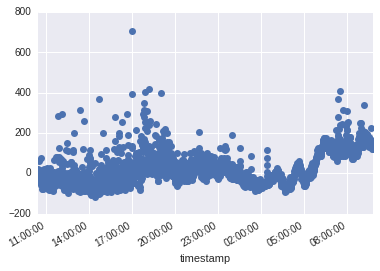

In [100]:
# One hour averages
ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').co_ppb.plot(linestyle='none', marker='o')

### compare to Kings

       kings_no2    no2_ppb
count  19.000000  20.000000
mean   52.392931  13.955239
std     9.749879   3.465699
min    36.768175   7.587972
25%    45.259812  11.178508
50%    51.498600  14.150453
75%    58.665725  16.673265
max    73.067325  19.323878


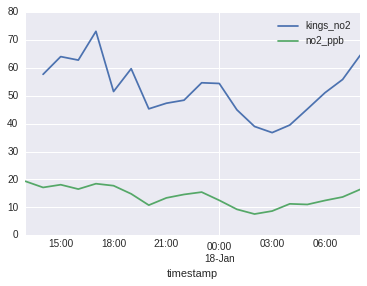

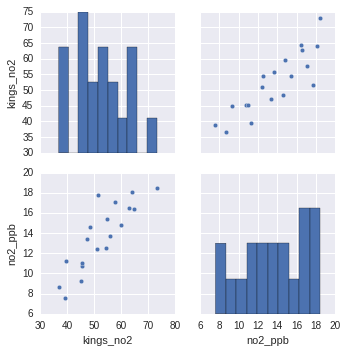

In [101]:

ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
compare(ds_merged,'kings_no2','no2_ppb')

# Pm10 OPC-N2 is spiking due to PCB in batch 17639

       kings_pm10        pm10
count   20.000000   20.000000
mean    58.368885   47.252279
std     11.370683   47.401765
min     43.119607   16.836222
25%     51.234482   22.076440
50%     55.703788   33.176817
75%     62.594729   38.825096
max     88.085102  215.159352


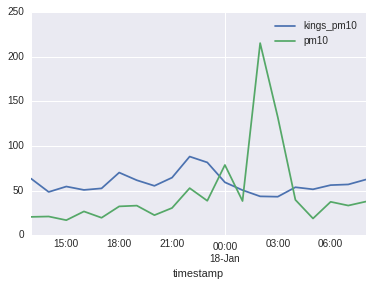

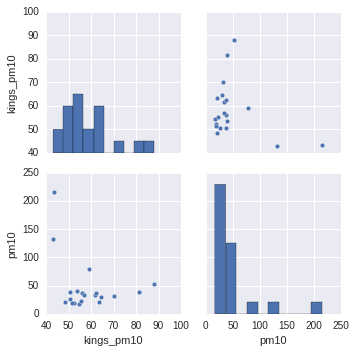

In [102]:
compare(ds_merged, 'kings_pm10', 'pm10')